# Cluster study.

The purpose of this notebook is to study the relationship between scaled mutual information and the dissimilarity of closely-scored feature sets.

### Imports & requisites.

In [29]:
# Libraries.
library(pacman)
pacman::p_load(
    ,tidyverse
    ,stringdist
    ,reshape2
    ,repr
    ,gridExtra
    ,ggforce
    ,cowplot
)
options(repr.plot.width = 12, repr.plot.height = 10)
# Load data.
# ## This requires the `UNSEEN_evaluate_feature_sets.ipynb`
# ##notebook to have been run to produce eval_output.csv.
eval_output <- readr::read_csv('eval_output.csv', show_col_types = FALSE)


Your package installed

Warning message in pacman::p_load(, tidyverse, stringdist, reshape2, repr, gridExtra, :
“Failed to install/load:
”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


## Converging on a concept of complex mental health difficulties?

We might like to have a distinct set of very-similar high-scoring feature sets that huddle around some latent, concetrated, strong concept of complex mental health difficulties (CMHD). This would be evidenced by a) our high-scoring feature sets being definitionally similar, and c) our high-scoring feature sets being dissimilar to the low scoring feature sets. This is similar to the idea of good clustering where we want observations within clusters to be similar to each other, but observations between clusters to be different. This and other possibilities are summarised, below:

1. similar high scorers AND dissimilar to low scorers
    
    -> good coherence and good separation.
    
    -> landscape = high peak with gentle slopes, i.e. we won't lose height if we are a few steps to the left or right.
    
    -> if we have found some latent concept of CMHD, it is concetrated and strong.
    
    -> observations through our lenses are robust to some imperfections in the lenses, and, as a bonus, CMHD is easy to spot, anyway.
    
2. similar high scorers BUT similar to low scorers
    
    -> good coherence but poor separation.
    
    -> landscape = high peak with steep slopes, i.e. we will lose height if we are a few steps to the left or right.
    
    -> if we have found some latent concept of CMHD, it is concetrated and weak.
        
    -> observations through our lenses are robust to imperfections in the lenses, but, unfortunately CMHD is hard to spot regardless of lens.
    
3. dissimilar high scorers BUT dissimilar to low scorers
    
    -> poor coherence but good separation.
    
    -> landscape = many gentle hills.
    
    -> if we have found some latent concept of CMHD, it is diffuse and strong but disinctly complicated rather than complex.
    
    -> observations through our lenses are sensitive to imperfections in the lenses but, fortunately, CMHD is easy to spot.
    
4. dissimilar high scorers AND similar to low scorers 

    -> poor coherence and poor separation.
    
    -> landscape = many rock towers.
    
    -> if we have found some latent concept of CMHD, it is diffuse and weak.
    
    -> observations through our lenses are sensitive to imperfections in the lenses, and, to make matters worse, CMHD is hard to spot regardless of lens.

## Within-cluster investigation.

Below, I define clusters based on intervals of scaled mutual information and then calculate the within-cluster similarity of the feature-set definition. For example, A2_C2_S1_Tx_Kx_P2_Rx_Y0 is very similar to A2_C2_Sx_Tx_Kx_P2_Rx_Y0 because the only difference is S1 and Sx. But A2_C2_S1_Tx_Kx_P2_Rx_Y0 is very different to Ax_Cx_Sx_T2_K2_x2_R1_Y1 because every component has changed.

A simple plot of each cluster's dissimilarity will tell me something about how similar the highest-scoring feature sets are to each other. This will help to determine which of the above four scenarios I am in. The steps I take to build the plot are:
1. Get the heights of the columns in the main histogram. These are the counts in each percentage-point interval group. They will be used to scale the similarity measure.
2. Get the mean and standard deviation of the Hamming distances for each percentage-point interval of scaled mutual information (sMI). This is the similarity measure.
3. Plot this quotient against increasing sMI.

### Get the heights of the columns in the main histogram.

I limit the counts to the feature sets that score >1% for scaled mutual information, and <24%. The lower bound is because there are so many feature sets scoring <1% that the computer gives up. The upper bound is because there is only one feature set in this highest of high "cluster".

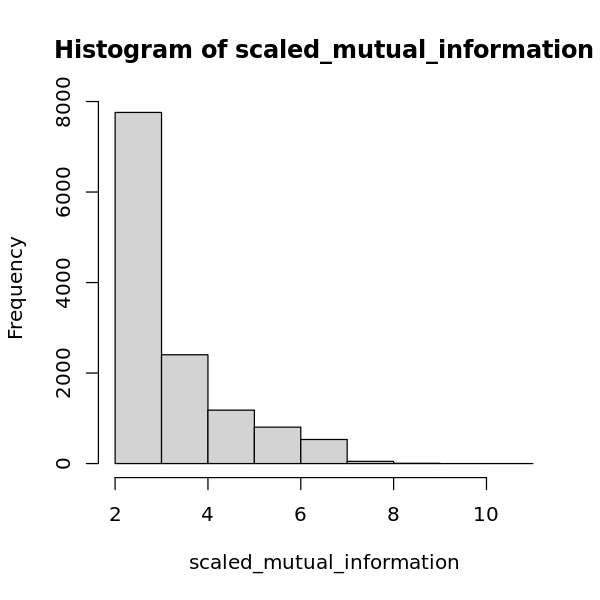

In [3]:
# Set plot display options
options(repr.plot.width = 5, repr.plot.height = 5)

# Calculations
scaled_mutual_information <-
    eval_output %>%
    dplyr::filter( grepl('A.*._C.*._S.*._T.*._K.*._P.*._R.*._Y.*.', Feature_set) & (Scaled_mutual_information > 0.02) & (Scaled_mutual_information < 0.24) ) %>%
    dplyr::select(Scaled_mutual_information) %>%
    `*`(100) %>%
    as.matrix()
myCounts <-
    hist(scaled_mutual_information, breaks = c(2:11) )$counts %>%
    dplyr::bind_cols(counts = ., sMI_group = c(">2", ">3", ">4", ">5", ">6", ">7", ">8", ">9", ">10"))
myCounts$sMI_group <- factor(myCounts$sMI_group, levels = c(">2", ">3", ">4", ">5", ">6", ">7", ">8", ">9", ">10") )   

### Get the mean and sd Hamming distances for each percentage-point interval of sMI.

I write a small function that summarises the Hamming distance matrix into mean and standard deviation. I scale the Hamming distance to its theoretical maximum, which in my case is eight. The big problem is that there are so many feature sets to get through that the Hamming distance matrix is gigabytes too large for the RAM. A solution I have adopted is to process each group separately, then combine them.

In [4]:
hamming_calc = function(x) {
    my_dist <-
        stringdist::stringdistmatrix(as.matrix(x), method = "hamming") %>%
        as.matrix() %>%
        reshape2::melt(varnames = c("row", "col")) %>%
        dplyr::filter(row > col) %>%
        dplyr::summarise(mean = mean(value),
                         sd = sd(value),
                         median = median(value),
                         qtr1 = quantile(value, 0.25),
                         qtr3 = quantile(value, 0.75)
                    ) %>%
        `/`(8)
     return (my_dist)
}

# Create two-column vector of feature-set name and sMI group.
fs_and_sMIgroup <- 
    eval_output %>% 
        dplyr::filter( grepl('A.*._C.*._S.*._T.*._K.*._P.*._R.*._Y.*.', Feature_set) & (Scaled_mutual_information > 0.02) & (Scaled_mutual_information < 0.24) ) %>%
        dplyr::mutate(
            sMI_group = 
                dplyr::case_when(
                    Scaled_mutual_information > 0.10 ~ '>10',
                    Scaled_mutual_information > 0.09 ~ '>9',
                    Scaled_mutual_information > 0.08 ~ '>8',
                    Scaled_mutual_information > 0.07 ~ '>7',
                    Scaled_mutual_information > 0.06 ~ '>6',
                    Scaled_mutual_information > 0.05 ~ '>5',
                    Scaled_mutual_information > 0.04 ~ '>4',
                    Scaled_mutual_information > 0.03 ~ '>3',
                    Scaled_mutual_information > 0.02 ~ '>2',
                    TRUE ~ NA_character_
                  )
        ) %>%
        dplyr::select(Feature_set, sMI_group)

# Process the sMI groups separately.
# ## Process the >10 group
msd_10 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>10') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >9 group
msd_9 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>9') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >8 group
msd_8 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>8') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >7 group
msd_7 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>7') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >6 group
msd_6 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>6') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >5 group
msd_5 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>5') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >4 group
msd_4 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>4') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >3 group
msd_3 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>3') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()
# ## Process the >2 group
msd_2 <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == '>2') %>%
    dplyr::select(Feature_set) %>%
    hamming_calc()

# Bind rows.
msd_all <-
    dplyr::bind_rows(
    msd_2, msd_3, msd_4, msd_5, msd_6, msd_7, msd_8, msd_9, msd_10) %>%
    dplyr::bind_cols(sMI_group = c(">2", ">3", ">4", ">5", ">6", ">7", ">8", ">9", ">10"))
msd_all$sMI_group <- factor( msd_all$sMI_group, levels = c(">2", ">3", ">4", ">5", ">6", ">7", ">8", ">9", ">10") )

### Plot this quotient against increasing sMI.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


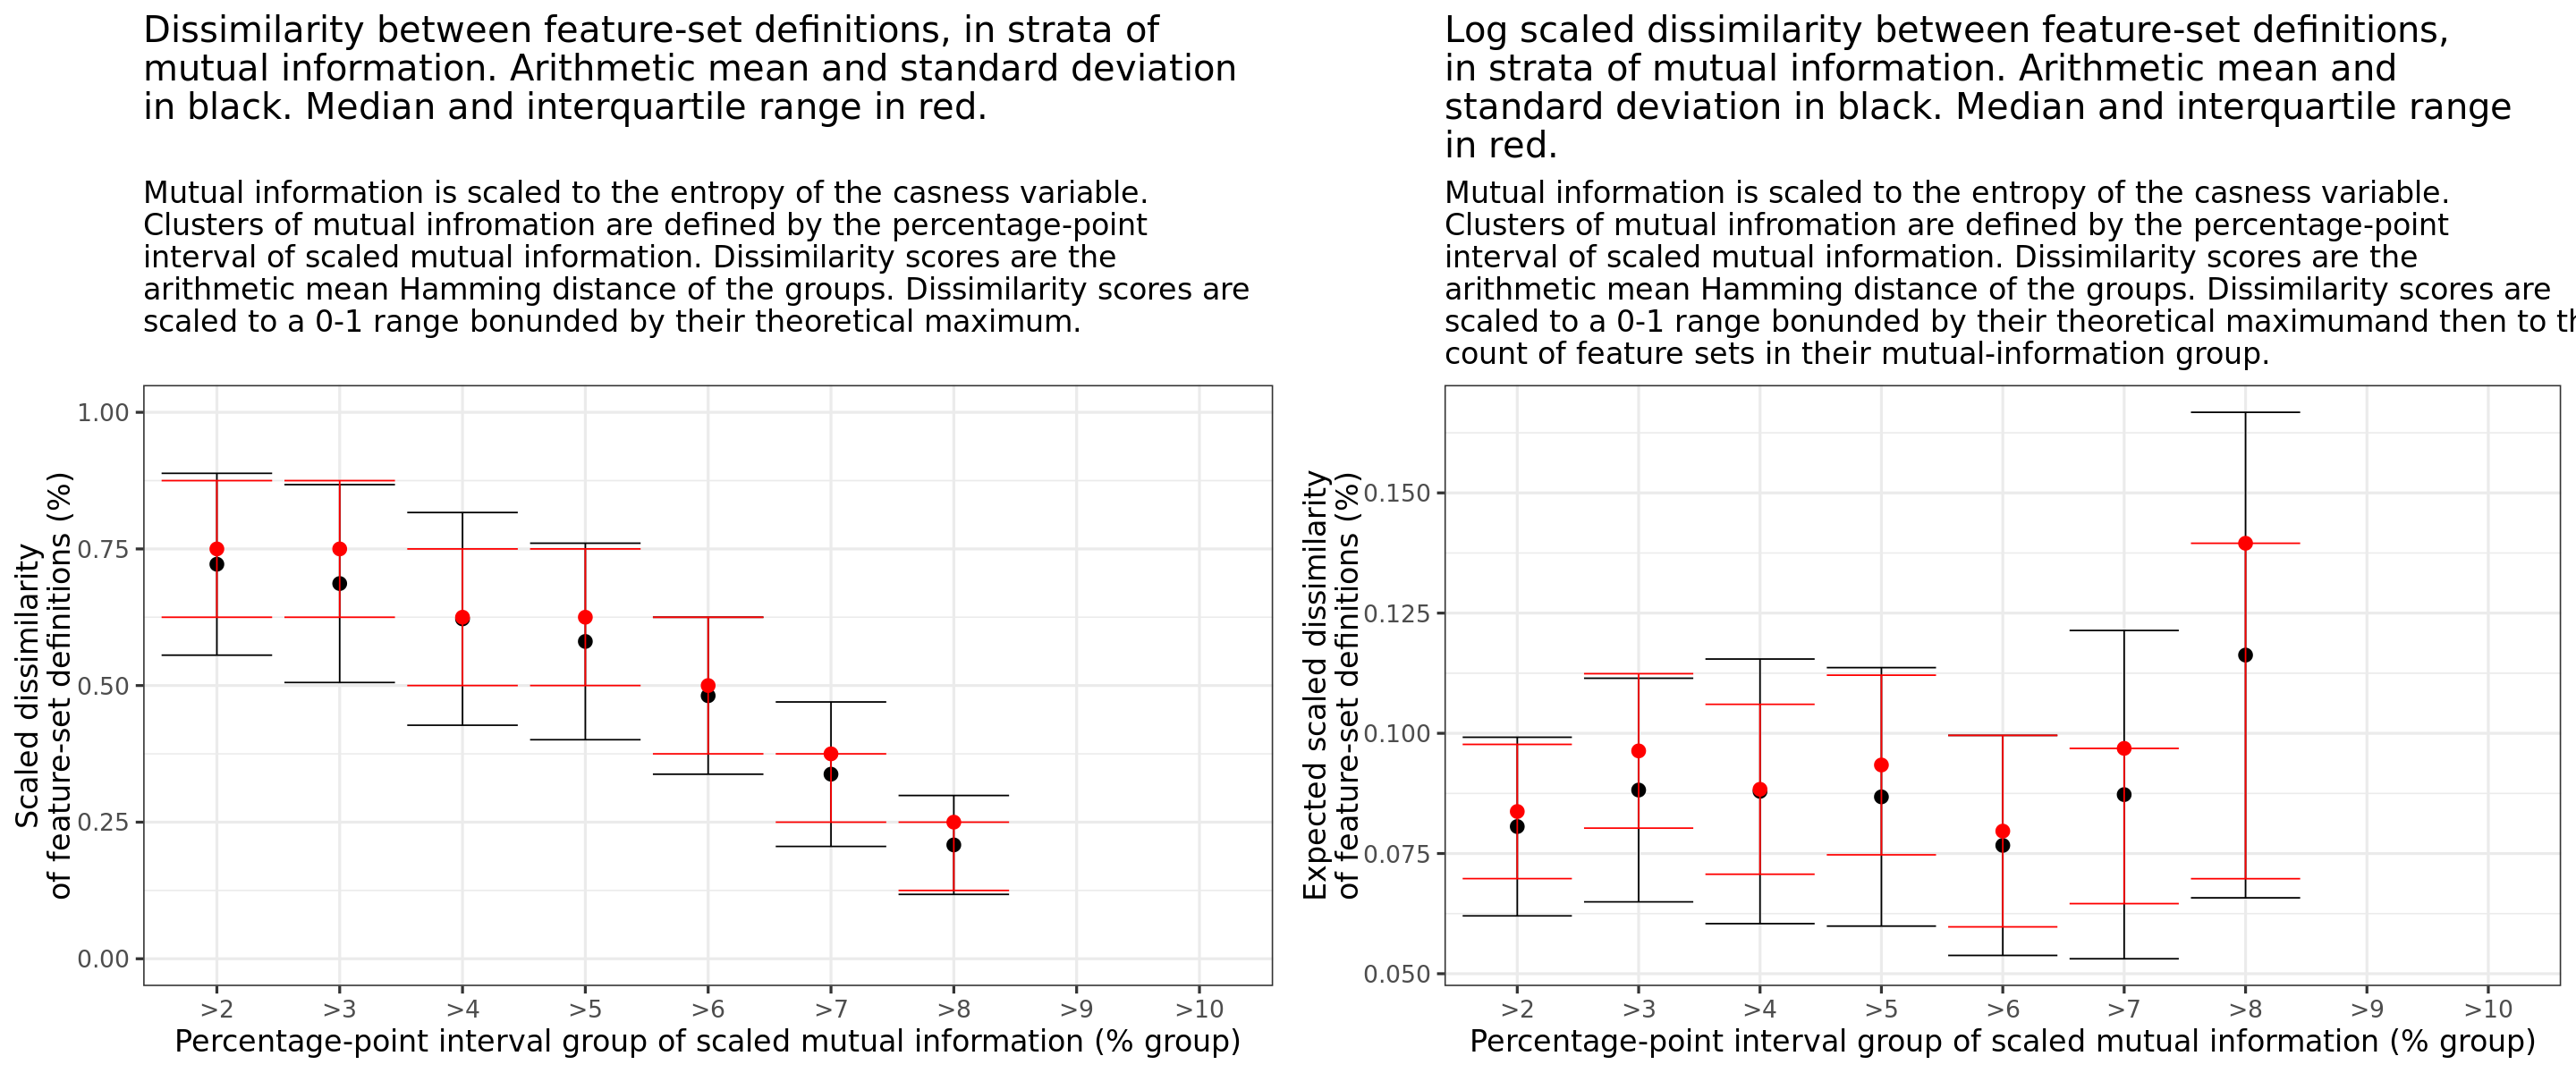

In [8]:
plot_similarity_vs_sMI <-
    merge(msd_all, myCounts, on = sMI_group) %>%
    ggplot(aes(x = sMI_group, y = mean)) +
    geom_point(size = 4) +
    geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), position = "dodge" ) +
    geom_point(aes(x = sMI_group, y = median), size = 4, colour = 'red') +
    geom_errorbar(aes(x = sMI_group, y = median, ymin = qtr1, ymax = qtr3), position = "dodge", colour = 'red') +
    ylim(c(0,1) )+
    labs(title =
         paste(
             strwrap(
                 paste0('Dissimilarity between feature-set definitions, in strata of mutual information. ',
                       'Arithmetic mean and standard deviation in black. ',
                       'Median and interquartile range in red.'),
                 width = 60),
             collapse = "\n"),
         x = 'Percentage-point interval group of scaled mutual information (% group)',
         y = 'Scaled dissimilarity\nof feature-set definitions (%)',
         subtitle =
             paste(
                 strwrap(
                     paste0('Mutual information is scaled to the entropy of the casness variable. ',
                            'Clusters of mutual infromation are defined by the percentage-point ',
                            'interval of scaled mutual information. ',
                            'Dissimilarity scores are the arithmetic mean Hamming distance of the groups. ',
                            'Dissimilarity scores are scaled to a 0-1 range bonunded by their theoretical maximum.'), 
                     width = 75),
                 collapse = "\n")
      ) +
    theme_bw(base_size = 20)

plot_scaled_similarity_vs_sMI <-
    merge(msd_all, myCounts, on = sMI_group) %>%
     dplyr::mutate(
        sMean = mean / log(counts),
        sSD = sd / log(counts),
        sMedian = median / log(counts),
        sQtr1 = qtr1 / log(counts),
        sQtr3 = qtr3 / log(counts),
    ) %>%
    ggplot(aes(x = sMI_group, y = sMean)) +
    geom_point(size = 4) +
    geom_errorbar(aes(ymin = sMean - sSD, ymax = sMean + sSD), position = "dodge" ) +
    geom_point(aes(x = sMI_group, y = sMedian), size = 4, colour = 'red') +
    geom_errorbar(aes(x = sMI_group, y = sMedian, ymin = sQtr1, ymax = sQtr3), position = "dodge", colour = 'red') +
    #ylim(c(0,1)) + # Constraining the dissimilarity axis is useful if Idon't log the dissiilarity score.
    labs(title = 
             paste(
                 strwrap(
                     paste0('Log scaled dissimilarity between feature-set definitions, in strata of mutual information. ', # Need to change this if not using the log scale.
                           'Arithmetic mean and standard deviation in black. ',
                           'Median and interquartile range in red.'),
                     width = 60),
                 collapse = "\n"),
         x = 'Percentage-point interval group of scaled mutual information (% group)',
         y = 'Expected scaled dissimilarity\nof feature-set definitions (%)',
         subtitle =
             paste(
                 strwrap(
                     paste0('Mutual information is scaled to the entropy of the casness variable. ',
                            'Clusters of mutual infromation are defined by the percentage-point ',
                            'interval of scaled mutual information. Dissimilarity scores are the ',
                            'arithmetic mean Hamming distance of the groups. ',
                            'Dissimilarity scores are scaled to a 0-1 range bonunded by their theoretical maximum',
                            'and then to the count of feature sets in their mutual-information group.'),
                     width = 75),
                 collapse = "\n")
      ) +
    #ggforce::facet_zoom(ylim = c(0, 0.025)) + # The `facet_zoom()` function is useful if I don't log the dissimilarity score.
    theme_bw(base_size = 20)

# Plot.
options(repr.plot.width = 24, repr.plot.height = 10) # A wider plot is better if I use the `facet_zoom()` function, e.g. repr.plot.width = 36.
cowplot::plot_grid(plot_similarity_vs_sMI,
                   plot_scaled_similarity_vs_sMI,
                   align = "h", nrow = 1,
                   rel_widths = c(1/2, 1/2)) # rel_widths = c(2/5, 3/5) if is better if I use the `facet_zoom()` function.

From the leftside plot shown above, I note:
1. The mean and median dissimilarity consistently descreases with improved mutual information.
2. The standard deviation improves slightly with improved mutual information, but is rather consistent across clusters. Interquartile range varies but is also rather consistent across clusters.

#### (Dis)similar high-scorers?
The fact that the mean and median dissimilarity is lower in high-scoring clusters tells us that higher-scoring clusters are more homogenous. The standard deviation of the highest scorers is also less than that of the other clusters but it is roughly the same. Generally, this suggests that the extent of dissimilarity in each cluster is similar. For example, lower-scoring clusters are robustly very dissimilar and higher-scoring clusters are robustly very similar.

#### What about cluster size?
I know that there are many more feature sets in the lower-scoring clusters. This means that the low-scoring cluster have more "opportunity" to be dissimilar, so we would expect them to have greater dissimilarity than the high-scoring clusters.

I wanted to test how the within-cluster dissimilarity is effected by the count of feature sets within the cluster. I scaled each cluster's arithmetic mean and standard deviation by the count of observations within the cluster. This is shown in the rightside plot. The vertical axis of the plot is on the log scale because the scaled dissimilarity values were so small, which is caused by there being so many hundreds of thousands of feature sets. I justify this log visualisation by noting that the count of feature sets within each successively lower-scoring cluster increases in orders of magnitude with each cluster.

I interpret the log-scaled dissimiarity statistics as indicating that, when adjusting for the log of cluster member counts, the feature sets within a clusters are similarly dissimilar, regardless of cluster. This means I do not change from my assertion above that lower-scoring clusters are robustly very dissimilar and higher-scoring clusters are robustly very similar.

#### (Dis)similar to low-scorers?
These plots aren't sufficient to tell us if the high-scorers are dissimilar to low scorers. The arithmetic mean of the highest scorers shows greater similarity than the low scorers but this just tells us something about the within-cluster coherence. The next step is to calculate the average dissimilarity between the features sets in pairs of clusters. To chunk the processing, I will calculate the distance matrices for pairs of clusters at a time. Also, I will not compare all clusters to all others. Instead, I will only compare the highest-scoring cluster with all others so that the distance matrix isn't too large.

## Between cluster investigation

### Calculate the between cluster similarity.
I define the between-cluster similarity to be the grand mean of dissimilarity scores between each member of the highest-scoring cluster and all members of lower-scoring clusters. The process is to select each member of the highest scoring clusting in turn, calculate the distances between this member and all members of a given lower-scoring cluster, repeat for all members of the highest scoring cluster, then calculate the arithmetic mean. This gives the grand mean of dissimilarity scores specific to each lower scoring cluster. I also calculate the standard deviation.

In [26]:
# Define storage for the final output.
df_between_cluster_similarity <-
    data.frame(
        sMI_group = c(">2", ">3", ">4", ">5", ">6", ">7"),
        mean = numeric(6),
        sd = numeric(6),
        median = numeric(6),
        qtr1 = numeric(6),
        qtr3 = numeric(6)
    )

# Define the members of the highest-scoring cluster.
high_scorers <-
    fs_and_sMIgroup %>%
    dplyr::filter(sMI_group == ">8") %>%
    dplyr::select(Feature_set)

# Define the identifiers for the low-scoring clusters.
ls_low_scorers <- df_between_cluster_similarity$sMI_group

# Do the work.
for (i_ls in 1:length(ls_low_scorers) )
{
    # Choose cluster.
    cluster_of_lower_scorers <-
            fs_and_sMIgroup %>%
            dplyr::filter(sMI_group == ls_low_scorers[i_ls]) %>%
            dplyr::select(Feature_set) %>%
            as.matrix()
    
    for (i_hs in 1:nrow(high_scorers) )
    {
        # Choose member of highest-scoring cluster.
        high_scorer <- high_scorers$Feature_set[i_hs] %>% as.matrix()
        
        # Set storage for this high scorer's distances.
        hs_store <- c()
        
        # Calculate this high scorer's Hamming distances to each member of the lower-scoring cluster.
        MnAndSd <-
            stringdist::stringdist(high_scorer, cluster_of_lower_scorers, method = "hamming") %>%
            as.data.frame()
        
        # Append these distances to this high scorer's list of distances.
        hs_store <- c(hs_store, MnAndSd)
        
    }
    
    # Summarise the high scorer's distances, for this cluster.
    hs_summary <-
        hs_store %>%
        as.data.frame() %>%
        dplyr::summarise(
            mean = mean(.)
            ,sd = sd(.)
            ,median = median(.)
            ,qtr1 = quantile(., 0.25)
            ,qtr3 = quantile(., 0.75)
        ) %>%
    `/`(8) # Divide by 8 because the maximum Hamming distance is 8, because there are 8 feature families.
    
    # Store the summary of the high scorer's distances, for this cluster.
    df_between_cluster_similarity[i_ls,2:6] <- hs_summary
}
df_between_cluster_similarity

sMI_group,mean,sd,median,qtr1,qtr3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
>2,0.6840766,0.1479478,0.625,0.625,0.750
>3,0.6555740,0.1543974,0.625,0.500,0.750
>4,0.6187500,0.1398633,0.625,0.500,0.750
>5,0.5933230,0.1455645,0.625,0.500,0.750
>6,0.4797932,0.1402112,0.500,0.375,0.625
>7,0.4062500,0.1276319,0.375,0.375,0.500


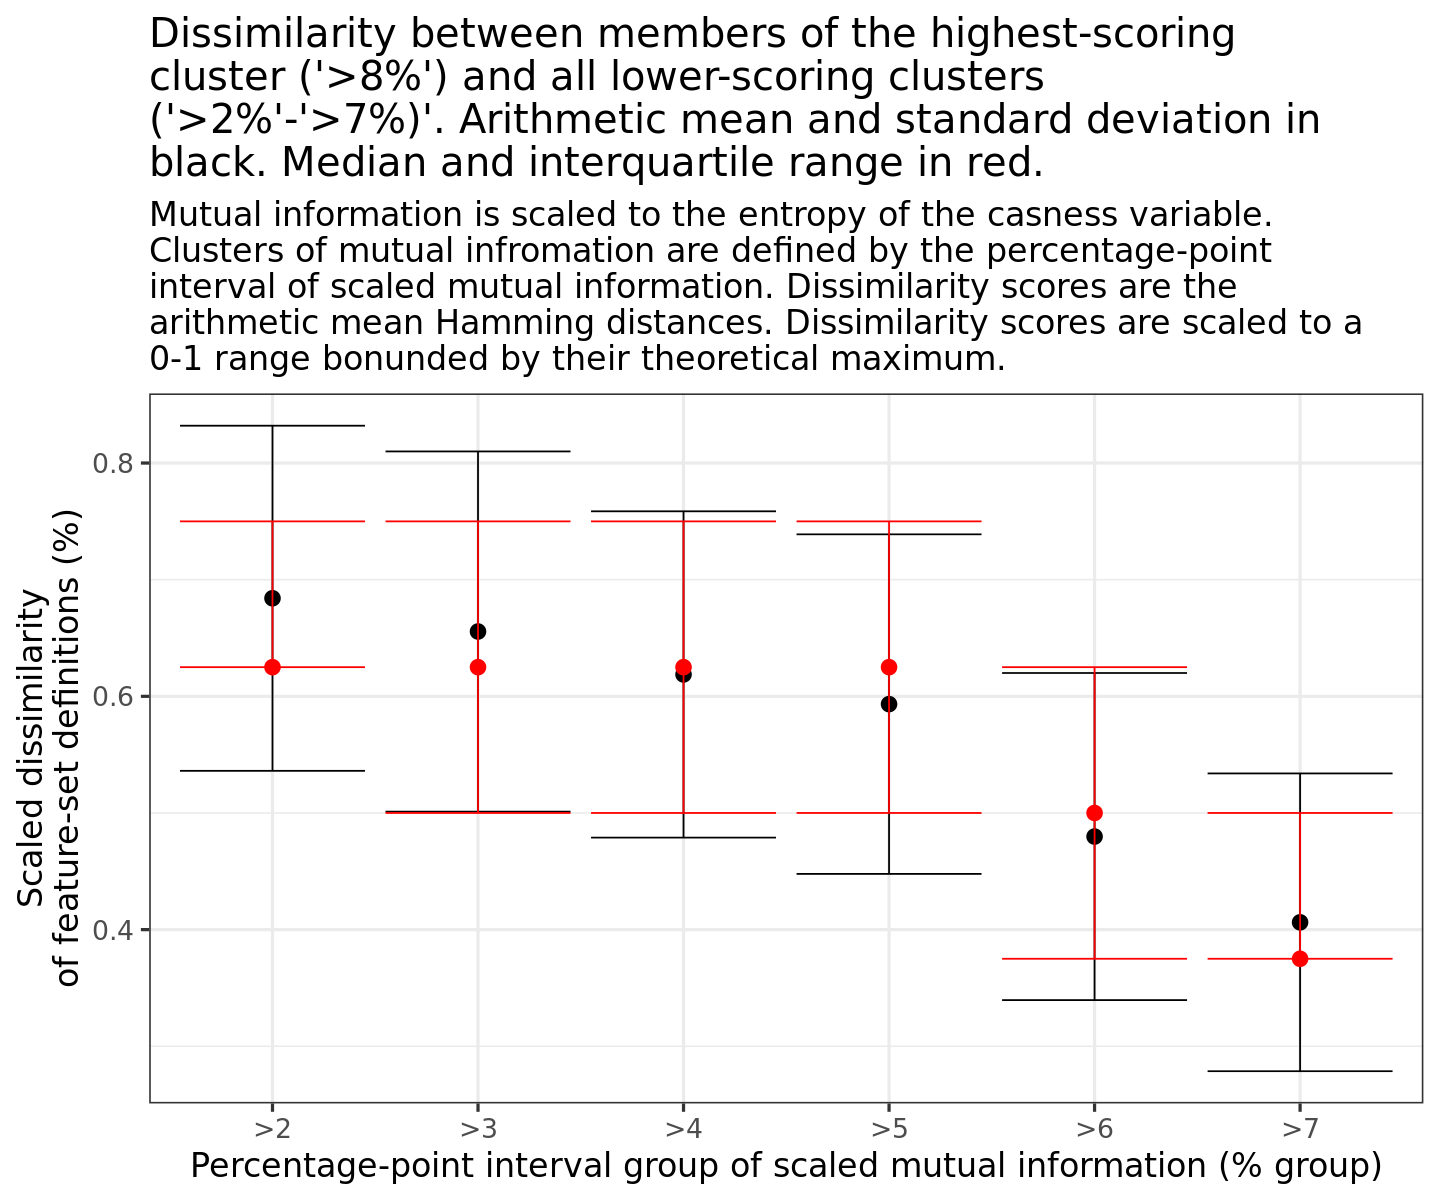

In [28]:
# Set plot display options
options(repr.plot.width = 12, repr.plot.height = 10)

# Plot
df_between_cluster_similarity %>%
ggplot(aes(x = sMI_group, y = mean)) +
    geom_point(size = 4) +
    geom_errorbar(aes(ymin = mean - sd, ymax = mean + sd), position = "dodge" ) +
    geom_point(aes(x = sMI_group, y = median), size = 4, colour = 'red') +
    geom_errorbar(aes(x = sMI_group, y = median, ymin = qtr1, ymax = qtr3), position = "dodge", colour = 'red') +
    labs(title =
             paste(
                 strwrap(
                     paste0('Dissimilarity between members of the highest-scoring cluster (\'>8%\') ',
                            'and all lower-scoring clusters (\'>2%\'-\'>7%)\'. ',
                            'Arithmetic mean and standard deviation in black. Median and interquartile range in red.'),
                     width = 60),
                 collapse = "\n"),
             x = 'Percentage-point interval group of scaled mutual information (% group)',
             y = 'Scaled dissimilarity\nof feature-set definitions (%)',
             subtitle =
                 paste(
                     strwrap(
                         paste0('Mutual information is scaled to the entropy of the casness variable. ',
                                'Clusters of mutual infromation are defined by the percentage-point ',
                                'interval of scaled mutual information. ',
                                'Dissimilarity scores are the arithmetic mean Hamming distances. ',
                                'Dissimilarity scores are scaled to a 0-1 range bonunded by their theoretical maximum.'), 
                         width = 75),
                     collapse = "\n")
          ) +
    theme_bw(base_size = 20)

The plot above shows a trend of greater dissimilarity in lower scoring clusters. In other words, on average, feature sets in lower scoring clusters are less similar to feature sets in the highest-scoring cluster.

#### (Dis)similar to low-scorers?
Importantly, lower-scoring feature sets are distinctly dissimilar to the highest-scoring feature sets, so small changes to the definitions of the highest-scoring feature sets are not likely to result in substantial changes to the scaled mutual information.

## Conclusion: Have we converged and what have we converged around?
Earlier, I explain the four possible scenarios that I might be in:
1. similar high scorers AND dissimilar to low scorers.
2. similar high scorers BUT similar to low scorers.
3. dissimilar highscorers BUT dissimilar to low scorers.
4. dissimilar high scorers AND similar to low scorers.

The first set of plots showed that our high scorers were tightly similar; more similar than any other cluster. The second plot (just above) showed that the highest-scoring feature sets are very dissimilar to the lowest-scoring features, and that there is a gradual trend of lower similarity with lower scaled mutual information.

These findings match with the first scenario I listed: similar high scorers AND dissimilar to low scorers. Characteristics of this scenario are:
- good coherence within cluster, and good separation between distant clusters.
- landscape = high peak with gentle slopes. To match this image with the last plot, flip the trend vertically recalling that the vertical axis is __dis__ -similarity rather than similarity. If we assume higher ground is better, then we see a peak of similarity within the highest-scoring cluster, and a gradual descent in similarity to lower-scoring clusters. 
- if we have found some latent concept of complex mental health difficulties, it is concetrated and strong.
- observations through our lenses are robust to some imperfections in the lenses, and, as a bonus, complex mental health difficulties is easy to spot, anyway.

__It's the best outcome we could have hoped for.__